In [99]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [95]:
df = pd.read_parquet("./../data/raw/sample_data.parquet.gzip")

# Crear target
df['target'] = (df['ACTION'] == 'LIKE').astype(int)

# Ratio por plataforma
platform_stats = df.groupby('CLIENT_OS', observed=True).agg({
    'ACTION': 'count',
    'target': ['sum', 'mean']
}).round(4)

platform_stats.columns = ['total_interactions', 'total_likes', 'like_ratio']
platform_stats = platform_stats.sort_values('like_ratio', ascending=False)
platform_stats

,total_interactions,total_likes,like_ratio
CLIENT_OS,,,
iphone,3624,3058,0.8438
hisense,206,159,0.7718
android,22974,17510,0.7622
viziovia,652,468,0.7178
vizio,11337,8069,0.7117
appletv,8922,6187,0.6935
opera,126,87,0.6905
lg,9004,6135,0.6814
samsung,9786,6651,0.6796


## Chi-Square Test
Test if platform differences are statistically significant

Chi-cuadrado: 7440.955
P-value: 0.00e+00
Grados de libertad: 11

Las diferencias son ESTADÍSTICAMENTE SIGNIFICATIVAS
- P-value (0.00e+00) < 0.05
- Rechazamos hipótesis nula: las plataformas SÍ tienen diferentes like ratios


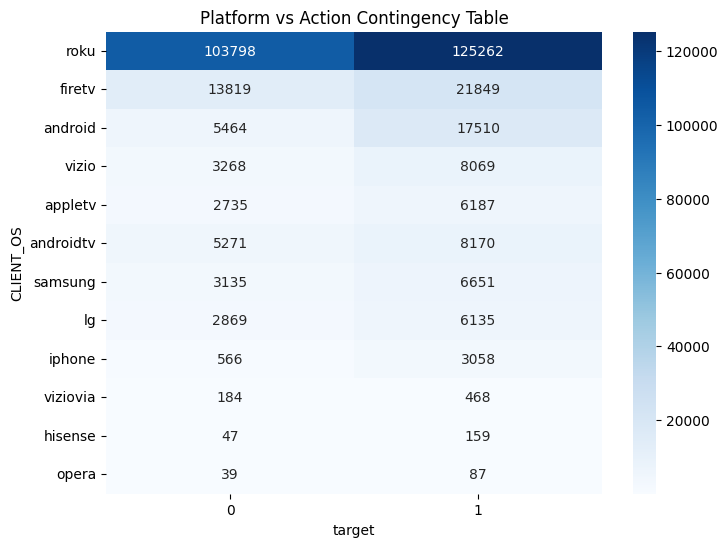

In [101]:
contingency_table = pd.crosstab(df['CLIENT_OS'], df['target'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square: {chi2:.3f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of freedom: {dof}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(f"\nDifferences are STATISTICALLY SIGNIFICANT")
    print(f"- P-value ({p_value:.2e}) < {alpha}")
    print(f"- Reject null hypothesis: platforms DO have different like ratios")
else:
    print(f"\nDifferences are NOT statistically significant")
    print(f"- P-value ({p_value:.2e}) >= {alpha}")

# Generate contingency table heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Platform vs Action Contingency Table')
plt.savefig('chi_square_test.png', dpi=300, bbox_inches='tight')
plt.show()

## Cramér's V (Effect Size)
Calculate how strong the relationship is between platform and likes

In [109]:
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * min(contingency_table.shape) - 1))

# Interpret effect size
if cramers_v < 0.1:
    effect_size = "small"
elif cramers_v < 0.3:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"Cramér's V: {cramers_v:.3f} ({effect_size} effect)")

Cramér's V: 0.104 (medium effect)


## Platform Comparison Chart
Visualize like ratios across platforms with overall average

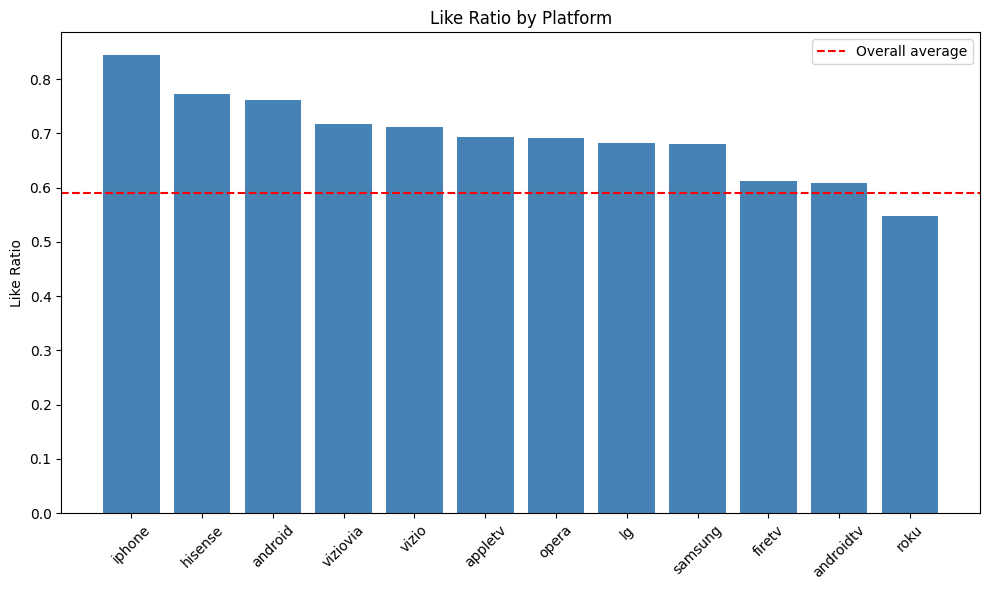

iPhone beats Roku by 29.7 percentage points


In [111]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(platform_stats)), platform_stats['like_ratio'], color='steelblue')
plt.xticks(range(len(platform_stats)), platform_stats.index, rotation=45)
plt.ylabel('Like Ratio')
plt.title('Like Ratio by Platform')
plt.axhline(y=df['target'].mean(), color='red', linestyle='--', label='Overall average')
plt.legend()
plt.tight_layout()
plt.savefig('like_ratio_platform.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate difference between best and worst platforms
best_platform = platform_stats.index[0]
worst_platform = platform_stats.index[-1]
best_ratio = platform_stats.loc[best_platform, 'like_ratio']
worst_ratio = platform_stats.loc[worst_platform, 'like_ratio']

print(f"iPhone beats Roku by {(best_ratio-worst_ratio)*100:.1f} percentage points")